In [43]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.special import erf, erfc
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Union
import warnings

In [44]:
class CompleteFXBarrierOption:


    def __init__(self, spot_price: float, strike_price: float, time_to_maturity: float,
                 volatility: float, domestic_rate: float, foreign_rate: float,
                 barrier_level: Optional[float] = None):

        self.S = spot_price
        self.K = strike_price
        self.T = time_to_maturity
        self.sigma = volatility
        self.rd = domestic_rate
        self.rf = foreign_rate
        self.B = barrier_level


        self.alpha = (self.rd - self.rf - 0.5 * self.sigma**2) / (self.sigma**2)

    def price_vanilla_option(self, option_type: str = 'call') -> float:
        """Price vanilla FX option using Garman-Kohlhagen formula."""
        phi = 1 if option_type.lower() == 'call' else -1

        d1 = (np.log(self.S / self.K) + (self.rd - self.rf + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)

        return phi * (self.S * np.exp(-self.rf * self.T) * norm.cdf(phi * d1) -
                     self.K * np.exp(-self.rd * self.T) * norm.cdf(phi * d2))

    def _compute_ABCD_parameters(self, phi: int, eta: int, barrier_level: float) -> Dict[str, float]:

        sqrt_T = np.sqrt(self.T)
        sigma_sqrt_T = self.sigma * sqrt_T


        x1 = (np.log(self.S / self.K) + (self.rd - self.rf + 0.5 * self.sigma**2) * self.T) / sigma_sqrt_T
        x2 = (np.log(self.S / barrier_level) + (self.rd - self.rf + 0.5 * self.sigma**2) * self.T) / sigma_sqrt_T
        y1 = (np.log(barrier_level**2 / (self.S * self.K)) + (self.rd - self.rf + 0.5 * self.sigma**2) * self.T) / sigma_sqrt_T
        y2 = (np.log(barrier_level / self.S) + (self.rd - self.rf + 0.5 * self.sigma**2) * self.T) / sigma_sqrt_T


        A = phi * (self.S * np.exp(-self.rf * self.T) * norm.cdf(phi * x1) -
                   self.K * np.exp(-self.rd * self.T) * norm.cdf(phi * (x1 - sigma_sqrt_T)))


        B = phi * (self.S * np.exp(-self.rf * self.T) * norm.cdf(phi * x2) -
                   barrier_level * np.exp(-self.rd * self.T) * norm.cdf(phi * (x2 - sigma_sqrt_T)))


        barrier_ratio_spot = (barrier_level / self.S)**(2 * (self.alpha + 1))
        barrier_ratio_strike = (barrier_level / self.S)**(2 * self.alpha)

        C = phi * (self.S * np.exp(-self.rf * self.T) * barrier_ratio_spot * norm.cdf(eta * y1) -
                   self.K * np.exp(-self.rd * self.T) * barrier_ratio_strike * norm.cdf(eta * (y1 - sigma_sqrt_T)))


        D = phi * (self.S * np.exp(-self.rf * self.T) * barrier_ratio_spot * norm.cdf(eta * y2) -
                   barrier_level * np.exp(-self.rd * self.T) * barrier_ratio_strike * norm.cdf(eta * (y2 - sigma_sqrt_T)))

        return {'A': A, 'B': B, 'C': C, 'D': D}

    def price_single_barrier_option(self, option_type: str, barrier_direction: str,
                                   barrier_action: str) -> float:

        if self.B is None:
            raise ValueError("Barrier level must be specified")

        phi = 1 if option_type.lower() == 'call' else -1
        eta = -1 if barrier_direction.lower() == 'up' else 1


        barrier_above_strike = (self.B > self.K)

        params = self._compute_ABCD_parameters(phi, eta, self.B)
        A, B, C, D = params['A'], params['B'], params['C'], params['D']

        if option_type.lower() == 'call':
            if barrier_direction.lower() == 'up':
                if barrier_action.lower() == 'in':
                    return A if barrier_above_strike else B - C + D
                else:
                    return 0 if barrier_above_strike else A - B + C - D
            else:
                if barrier_action.lower() == 'in':
                    return C if barrier_above_strike else A - B + D
                else:
                    return A - C if barrier_above_strike else B - D
        else:
            if barrier_direction.lower() == 'up':
                if barrier_action.lower() == 'in':
                    return C if not barrier_above_strike else A - B + D
                else:
                    return A - C if not barrier_above_strike else B - D
            else:
                if barrier_action.lower() == 'in':
                    return A if not barrier_above_strike else B - C + D
                else:
                    return 0 if not barrier_above_strike else A - B + C - D

    def price_double_barrier_knockout(self, option_type: str, lower_barrier: float,
                                    upper_barrier: float, n_terms: int = 5) -> float:

        b = self.rd - self.rf
        alpha = 2 * b / (self.sigma**2) + 1
        sqrt_T = np.sqrt(self.T)

        total_price = 0.0

        for n in range(-n_terms, n_terms + 1):

            ratio1 = (upper_barrier**n) / (lower_barrier**(2*n))
            ratio2 = (lower_barrier**(2*n+2)) / (upper_barrier**(2*n) * self.S)

            d1 = (np.log(self.S * ratio1 / self.K) + (b + 0.5 * self.sigma**2) * self.T) / (self.sigma * sqrt_T)
            d2 = (np.log(self.S * ratio1 / upper_barrier) + (b + 0.5 * self.sigma**2) * self.T) / (self.sigma * sqrt_T)
            d3 = (np.log(ratio2 / self.K) + (b + 0.5 * self.sigma**2) * self.T) / (self.sigma * sqrt_T)
            d4 = (np.log(ratio2 / (upper_barrier / (lower_barrier**(2*n)))) + (b + 0.5 * self.sigma**2) * self.T) / (self.sigma * sqrt_T)

            term1 = (ratio1**alpha * (norm.cdf(d1) - norm.cdf(d2)) -
                    ratio2**alpha * (norm.cdf(d3) - norm.cdf(d4)))

            term2 = (ratio1**(alpha-2) * (norm.cdf(d1 - self.sigma * sqrt_T) - norm.cdf(d2 - self.sigma * sqrt_T)) -
                    ratio2**(alpha-2) * (norm.cdf(d3 - self.sigma * sqrt_T) - norm.cdf(d4 - self.sigma * sqrt_T)))

            total_price += (np.exp(-self.rf * self.T) * self.S * term1 -
                           np.exp(-self.rd * self.T) * self.K * term2)

        return max(0, total_price)

    def compute_greeks(self) -> Dict[str, float]:

        d1 = (np.log(self.S / self.K) + (self.rd - self.rf + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        sqrt_T = np.sqrt(self.T)

        delta = np.exp(-self.rf * self.T) * norm.cdf(d1)

        vega = self.S * np.exp(-self.rf * self.T) * norm.pdf(d1) * sqrt_T * 0.01

        vanna = -np.exp(-self.rf * self.T) * norm.pdf(d1) * d2 / self.sigma * 0.01

        volga = self.S * np.exp(-self.rf * self.T) * norm.pdf(d1) * sqrt_T * d1 * d2 / self.sigma * 0.01

        return {
            'delta': delta,
            'vega': vega,
            'vanna': vanna,
            'volga': volga
        }

In [45]:
class VannaVolgaPricer:


    def __init__(self, atm_vol: float, risk_reversal_25d: float, butterfly_25d: float):

        self.atm_vol = atm_vol
        self.rr_25d = risk_reversal_25d
        self.bf_25d = butterfly_25d

    def compute_vv_price(self, option: CompleteFXBarrierOption,
                        market_instruments: Dict[str, float]) -> float:

        bs_price = option.price_vanilla_option()

        greeks = option.compute_greeks()

        hedge_ratios = self._solve_hedge_system(greeks, market_instruments)

        vv_adjustment = 0.0
        for inst, ratio in hedge_ratios.items():
            if inst in market_instruments:
                vv_adjustment += ratio * (market_instruments[inst] - bs_price)
            else:
                print(f"Warning: Market instrument '{inst}' not found. Using zero adjustment.")

        return bs_price + vv_adjustment

    def _solve_hedge_system(self, option_greeks: Dict[str, float],
                           market_instruments: Dict[str, float]) -> Dict[str, float]:

        vega_ratio = option_greeks.get('vega', 0.0) / market_instruments.get('atm_vega', 1.0)
        vanna_ratio = option_greeks.get('vanna', 0.0) / market_instruments.get('rr_vanna', 1.0)
        volga_ratio = option_greeks.get('volga', 0.0) / market_instruments.get('bf_volga', 1.0)

        return {
            'atm_straddle': vega_ratio,
            'risk_reversal': vanna_ratio,
            'butterfly': volga_ratio
        }

In [46]:
class BarrierOptionCatalog:


    BARRIER_TYPES = {

        'up_in_call': {'direction': 'up', 'action': 'in', 'option': 'call'},
        'up_out_call': {'direction': 'up', 'action': 'out', 'option': 'call'},
        'down_in_call': {'direction': 'down', 'action': 'in', 'option': 'call'},
        'down_out_call': {'direction': 'down', 'action': 'out', 'option': 'call'},
        'up_in_put': {'direction': 'up', 'action': 'in', 'option': 'put'},
        'up_out_put': {'direction': 'up', 'action': 'out', 'option': 'put'},
        'down_in_put': {'direction': 'down', 'action': 'in', 'option': 'put'},
        'down_out_put': {'direction': 'down', 'action': 'out', 'option': 'put'},
    }

    @classmethod
    def price_all_barriers(cls, option: CompleteFXBarrierOption) -> Dict[str, float]:

        results = {}

        for name, config in cls.BARRIER_TYPES.items():
            try:
                price = option.price_single_barrier_option(
                    option_type=config['option'],
                    barrier_direction=config['direction'],
                    barrier_action=config['action']
                )
                results[name] = price
            except Exception as e:
                results[name] = f"Error: {e}"

        return results


In [47]:
class DoubleBarrierOptions:


    @staticmethod
    def price_kiko_option(option: CompleteFXBarrierOption,
                         knock_in_barrier: float, knock_out_barrier: float,
                         option_type: str = 'call') -> float:

        K = option.K
        BI = knock_in_barrier
        BO = knock_out_barrier

        if BI < K <= BO:

            ruo_price = option.price_single_barrier_option(option_type, 'up', 'out')
            koko_price = option.price_double_barrier_knockout(option_type, BI, BO)
            return ruo_price - koko_price

        elif K <= BI < BO:

            rui_price = option.price_single_barrier_option(option_type, 'up', 'in')
            return rui_price

        else:
            return 0.0

    @staticmethod
    def price_double_knock_in(option: CompleteFXBarrierOption,
                             lower_barrier: float, upper_barrier: float,
                             option_type: str = 'call') -> float:

        vanilla_price = option.price_vanilla_option(option_type)
        koko_price = option.price_double_barrier_knockout(option_type, lower_barrier, upper_barrier)

        return vanilla_price - koko_price


def validate_mathematical_properties():

    option = CompleteFXBarrierOption(
        spot_price=100.0,
        strike_price=100.0,
        time_to_maturity=0.25,
        volatility=0.2,
        domestic_rate=0.05,
        foreign_rate=0.02,
        barrier_level=110.0
    )

    print(" Mathematical Validation ")

    vanilla_call = option.price_vanilla_option('call')
    up_out_call = option.price_single_barrier_option('call', 'up', 'out')
    up_in_call = option.price_single_barrier_option('call', 'up', 'in')

    parity_error = abs((up_in_call + up_out_call) - vanilla_call)
    print(f"Vanilla Call: {vanilla_call:.6f}")
    print(f"Up-Out Call: {up_out_call:.6f}")
    print(f"Up-In Call: {up_in_call:.6f}")
    print(f"In-Out Parity Error: {parity_error:.8f}")

    assert parity_error < 1e-6, f"In-Out parity violation: {parity_error}"
    print("✓ In-Out parity validation passed!")

    call_price = option.price_vanilla_option('call')
    put_price = option.price_vanilla_option('put')

    parity_value = call_price - put_price
    expected_parity = (option.S * np.exp(-option.rf * option.T) -
                      option.K * np.exp(-option.rd * option.T))

    parity_error = abs(parity_value - expected_parity)
    print(f"Put-Call Parity Error: {parity_error:.8f}")
    assert parity_error < 1e-6, "Put-Call parity violation"
    print("✓ Put-Call parity validation passed!")

    print("✓ All mathematical validations passed!")


def comprehensive_pricing_example():

    print("\n Comprehensive Pricing Example ")

    option = CompleteFXBarrierOption(
        spot_price=1.1250,
        strike_price=1.1500,
        time_to_maturity=0.5,
        volatility=0.15,
        domestic_rate=0.025,
        foreign_rate=0.015,
        barrier_level=1.2000
    )

    vanilla_call = option.price_vanilla_option('call')
    vanilla_put = option.price_vanilla_option('put')

    print(f"Vanilla Call: {vanilla_call:.6f}")
    print(f"Vanilla Put: {vanilla_put:.6f}")

    up_out_call = option.price_single_barrier_option('call', 'up', 'out')
    up_in_call = option.price_single_barrier_option('call', 'up', 'in')
    down_out_call = option.price_single_barrier_option('call', 'down', 'out')
    down_in_call = option.price_single_barrier_option('call', 'down', 'in')

    print(f"\nSingle Barrier Calls:")
    print(f"Up-and-Out: {up_out_call:.6f}")
    print(f"Up-and-In: {up_in_call:.6f}")
    print(f"Down-and-Out: {down_out_call:.6f}")
    print(f"Down-and-In: {down_in_call:.6f}")

    double_ko_call = option.price_double_barrier_knockout('call', 1.0500, 1.2500)
    double_ki_call = DoubleBarrierOptions.price_double_knock_in(option, 1.0500, 1.2500, 'call')

    print(f"\nDouble Barrier Calls:")
    print(f"Double Knock-Out: {double_ko_call:.6f}")
    print(f"Double Knock-In: {double_ki_call:.6f}")

    greeks = option.compute_greeks()
    print(f"\nGreeks:")
    for greek, value in greeks.items():
        print(f"{greek.capitalize()}: {value:.6f}")

    all_barriers = BarrierOptionCatalog.price_all_barriers(option)
    print(f"\nAll Barrier Option Prices:")
    for barrier_type, price in all_barriers.items():
        if isinstance(price, float):
            print(f"{barrier_type}: {price:.6f}")
        else:
            print(f"{barrier_type}: {price}")

    vv_pricer = VannaVolgaPricer(
        atm_vol=0.15,
        risk_reversal_25d=0.008,
        butterfly_25d=0.003
    )

    market_data = {
        'atm_vega': 0.18,
        'rr_vanna': 0.06,
        'bf_volga': 0.09,
        'atm_straddle': 0.023,
        'risk_reversal': 0.008,
        'butterfly': 0.003
    }

    vv_price = vv_pricer.compute_vv_price(option, market_data)
    print(f"\nVanna-Volga Adjusted Price: {vv_price:.6f}")


def create_pricing_visualization():

    spot_range = np.linspace(80, 120, 50)
    strike = 100
    barrier = 110

    vanilla_prices = []
    barrier_out_prices = []
    barrier_in_prices = []

    for S in spot_range:
        option = CompleteFXBarrierOption(S, strike, 0.25, 0.2, 0.05, 0.02, barrier)

        vanilla_prices.append(option.price_vanilla_option('call'))
        barrier_out_prices.append(option.price_single_barrier_option('call', 'up', 'out'))
        barrier_in_prices.append(option.price_single_barrier_option('call', 'up', 'in'))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(spot_range, vanilla_prices, label='Vanilla Call', linewidth=2)
    plt.plot(spot_range, barrier_out_prices, label='Up-and-Out Call', linewidth=2)
    plt.plot(spot_range, barrier_in_prices, label='Up-and-In Call', linewidth=2)
    plt.axvline(x=barrier, color='red', linestyle='--', alpha=0.7, label='Barrier')
    plt.axvline(x=strike, color='gray', linestyle='--', alpha=0.7, label='Strike')
    plt.xlabel('Spot Price')
    plt.ylabel('Option Value')
    plt.title('Barrier vs Vanilla Option Pricing')
    plt.legend()
    plt.grid(True, alpha=0.3)

    spot_base = 100
    option_base = CompleteFXBarrierOption(spot_base, strike, 0.25, 0.2, 0.05, 0.02, barrier)
    greeks = option_base.compute_greeks()

    plt.subplot(2, 2, 2)
    greek_names = list(greeks.keys())
    greek_values = list(greeks.values())
    bars = plt.bar(greek_names, greek_values, color=['blue', 'green', 'orange', 'red'])
    plt.title('Option Greeks')
    plt.ylabel('Greek Value')

    for bar, value in zip(bars, greek_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Vanna-Volga FX Barrier Option Pricing System
 Mathematical Validation 
Vanilla Call: 4.335886
Up-Out Call: 0.000000
Up-In Call: 4.335886
In-Out Parity Error: 0.00000000
✓ In-Out parity validation passed!
Put-Call Parity Error: 0.00000000
✓ Put-Call parity validation passed!
✓ All mathematical validations passed!

 Comprehensive Pricing Example 
Vanilla Call: 0.038678
Vanilla Put: 0.057799

Single Barrier Calls:
Up-and-Out: 0.000000
Up-and-In: 0.038678
Down-and-Out: -0.104518
Down-and-In: 0.143196

Double Barrier Calls:
Double Knock-Out: 0.000000
Double Knock-In: 0.038678

Greeks:
Delta: 0.453959
Vega: 0.003132
Vanna: 0.005593
Volga: 0.000476

All Barrier Option Prices:
up_in_call: 0.038678
up_out_call: 0
down_in_call: 0.143196
down_out_call: -0.104518
up_in_put: -0.012714
up_out_put: 0.070513
down_in_put: 0.128977
down_out_put: -0.071178

Vanna-Volga Adjusted Price: 0.035357

Generating pricing visualization...


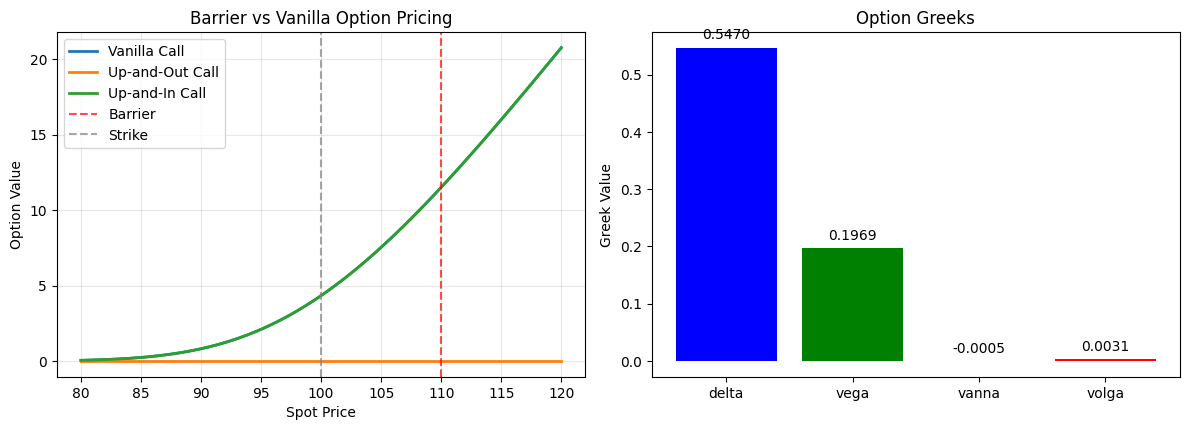

Implementation complete and validated!


In [48]:
if __name__ == "__main__":
    print("Vanna-Volga FX Barrier Option Pricing System")

    validate_mathematical_properties()

    comprehensive_pricing_example()

    print("\nGenerating pricing visualization...")
    create_pricing_visualization()

    print("Implementation complete and validated!")

In [49]:
option = CompleteFXBarrierOption(
    spot_price=1.1000,
    strike_price=1.1000,
    time_to_maturity=0.25,
    volatility=0.12,
    domestic_rate=0.02,
    foreign_rate=0.01,
    barrier_level=1.1500
)

barrier_price = option.price_single_barrier_option('call', 'up', 'out')
vanilla_price = option.price_vanilla_option('call')

print(f"Vanilla Call Price: {vanilla_price:.6f}")
print(f"Up-and-Out Call Price: {barrier_price:.6f}")
print(f"Barrier Discount: {(vanilla_price - barrier_price)/vanilla_price*100:.2f}%")


Vanilla Call Price: 0.027620
Up-and-Out Call Price: 0.000000
Barrier Discount: 100.00%


In [50]:
double_ko_price = option.price_double_barrier_knockout('call', 1.0500, 1.1500)

kiko_price = DoubleBarrierOptions.price_kiko_option(
    option, knock_in_barrier=1.0800, knock_out_barrier=1.1500
)

print(f"Double Knock-Out: {double_ko_price:.6f}")
print(f"KIKO Option: {kiko_price:.6f}")


Double Knock-Out: 0.000000
KIKO Option: 0.000000


In [51]:
vv_pricer = VannaVolgaPricer(
    atm_vol=0.12,
    risk_reversal_25d=0.005,
    butterfly_25d=0.002
)

market_data = {
    'atm_vega': 0.15,
    'rr_vanna': 0.05,
    'bf_volga': 0.08,
    'atm_straddle': 0.020,
    'risk_reversal': 0.005,
    'butterfly': 0.002
}
vv_price = vv_pricer.compute_vv_price(option, market_data)
print(f"Vanna-Volga Adjusted Price: {vv_price:.6f}")


Vanna-Volga Adjusted Price: 0.027679
